In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import regex as re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
## locations

train_data_location = "data/train.csv"
test_data_location = "data/test.csv"


In [3]:
df_train = pd.read_csv(train_data_location)
df_test = pd.read_csv(test_data_location)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


### Feature Engineering based on analysis

In [6]:
def _risk_name_title(row):
    if row['name_titles'] in ["Capt.","Don.","Jonkheer.","Mr.", "Rev."]:
        return "high_risk"
    elif row['name_titles'] in ["Lady.","Miss.","Mlle.","Mme.","Mrs.","Ms.","Sir."]:
        return "low_risk"
    else :
        return "medium_risk"
reg_exp = r'\s[A-Za-z]+\.'
df_train['name_titles']= df_train.Name.apply(lambda x: re.search(reg_exp,x).group().strip() if re.search(reg_exp,x) else "NA")
df_train['title_risk'] = df_train.apply(_risk_name_title,axis=1)
df_test['name_titles']= df_test.Name.apply(lambda x: re.search(reg_exp,x).group().strip() if re.search(reg_exp,x) else "NA")
df_test['title_risk'] = df_test.apply(_risk_name_title,axis=1)

In [7]:
df_train['Embarked']=df_train['Embarked'].fillna('S')
df_test['Embarked']=df_test['Embarked'].fillna('S')

In [8]:
def _impute_cabin_risk_title_based(row):
    if row['cabin_initial']=="NA":
        return row["title_risk"]
    else:
        if "B"<=row['cabin_initial']<="F":
            return "low_risk"
        else:
            return "high_risk"

df_train['cabin_initial'] = df_train.Cabin.apply(lambda x: "NA" if  type(x)==float else str(x[0]).upper())
df_train['cabin_risk']=df_train.apply(_impute_cabin_risk_title_based,axis=1)
df_test['cabin_initial'] = df_test.Cabin.apply(lambda x: "NA" if  type(x)==float else str(x[0]).upper())
df_test['cabin_risk']=df_test.apply(_impute_cabin_risk_title_based,axis=1)

In [9]:
df_train['no_cabins'] = df_train.Cabin.apply(lambda x: 1 if type(x)==float else len(x.split(' ')))
df_test['no_cabins']= df_test.Cabin.apply(lambda x: 1 if type(x)==float else len(x.split(' ')))

In [10]:
df_train['relation_count'] = df_train['SibSp']+df_train['Parch']
df_test['relation_count'] = df_test['SibSp']+df_test['Parch']

In [11]:
df_train['Fare']=df_train['Fare'].fillna(df_train['Fare'].median())
df_train['Fare']=np.sqrt(df_train['Fare'])
df_test['Fare']=df_test['Fare'].fillna(df_test['Fare'].median())
df_test['Fare']=np.sqrt(df_test['Fare'])


In [12]:
median_age_based_on_title = df_train.groupby('name_titles')['Age'].median().to_dict()
median_age_based_on_title['default']=df_train['Age'].median()
median_age_based_on_title

{'Capt.': 70.0,
 'Col.': 58.0,
 'Countess.': 33.0,
 'Don.': 40.0,
 'Dr.': 46.5,
 'Jonkheer.': 38.0,
 'Lady.': 48.0,
 'Major.': 48.5,
 'Master.': 3.5,
 'Miss.': 21.0,
 'Mlle.': 24.0,
 'Mme.': 24.0,
 'Mr.': 30.0,
 'Mrs.': 35.0,
 'Ms.': 28.0,
 'Rev.': 46.5,
 'Sir.': 49.0,
 'default': 28.0}

In [13]:
def _impute_age_title_based(row):
    #print(row['Age'])
    if np.isnan(row['Age']):
        if row['name_titles'] in median_age_based_on_title:
            return median_age_based_on_title[row['name_titles']]
        else:
            return median_age_based_on_title["default"]
    else:
        return row['Age']
        
df_train['Age'] = df_train.apply(_impute_age_title_based,axis=1)
df_test['Age'] = df_test.apply(_impute_age_title_based,axis=1)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             891 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           204 non-null    object 
 11  Embarked        891 non-null    object 
 12  name_titles     891 non-null    object 
 13  title_risk      891 non-null    object 
 14  cabin_initial   891 non-null    object 
 15  cabin_risk      891 non-null    object 
 16  no_cabins       891 non-null    int64  
 17  relation_count  891 non-null    int

In [15]:
df_train.columns = [col.lower() for col in df_train.columns]
df_test.columns = [col.lower() for col in df_test.columns]


### Select only useful feature and seperate the features and target.

In [16]:
df_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'name_titles',
       'title_risk', 'cabin_initial', 'cabin_risk', 'no_cabins',
       'relation_count'],
      dtype='object')

In [17]:
numeric_features = ['age', 'fare', 'no_cabins','relation_count']
categorical_features = ['pclass','sex','embarked','title_risk', 'cabin_risk']
target_col = 'survived'
passenger_id = 'passengerid'
all_features=numeric_features+categorical_features

In [18]:
X_all = df_train[all_features]
Y_all = df_train[target_col]
X_final_test = df_test[all_features]
X_final_passengerid = df_test[passenger_id]

In [19]:
X_all = pd.get_dummies(X_all,columns=categorical_features)
X_final_test = pd.get_dummies(X_final_test,columns=categorical_features)

In [20]:
X_all.columns

Index(['age', 'fare', 'no_cabins', 'relation_count', 'pclass_1', 'pclass_2',
       'pclass_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'title_risk_high_risk', 'title_risk_low_risk',
       'title_risk_medium_risk', 'cabin_risk_high_risk', 'cabin_risk_low_risk',
       'cabin_risk_medium_risk'],
      dtype='object')

In [21]:
X_final_test.columns

Index(['age', 'fare', 'no_cabins', 'relation_count', 'pclass_1', 'pclass_2',
       'pclass_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'title_risk_high_risk', 'title_risk_low_risk',
       'title_risk_medium_risk', 'cabin_risk_high_risk', 'cabin_risk_low_risk',
       'cabin_risk_medium_risk'],
      dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, random_state=333, train_size = 0.8)

## Get Cross validation set for the problem.

In [23]:
X_model_train, X_cv, y_model_train, y_cv = train_test_split(X_train, y_train, random_state=500, train_size = 0.9)

### Try different models

In [24]:
type(X_final_test)

pandas.core.frame.DataFrame

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV

In [48]:
def cv_report(model,x,y,cv):
    scores = cross_val_score(model,x,y,cv=cv)
    print("CV scores: ",scores)
    print(f"CV mean:{scores.mean()}, CV median:{sorted(scores)[cv//2]}!")
    
def produce_results(model_name,model,x_test,x_passid):
    y_test = model.predict(x_test)
    df_result = pd.DataFrame(columns=['PassengerId','Survived'])
    df_result['PassengerId'] = x_passid
    df_result['Survived']=y_test
    df_result.to_csv(f"{model_name}_predictions.csv",index=False)
    

#### Logistic regression

In [49]:
logistic_regression = LogisticRegression(max_iter=2000)
logistic_regression.fit(X_model_train,y_model_train)
scores = cv_report(logistic_regression,X_model_train,y_model_train,cv=5)


CV scores:  [0.890625  0.8046875 0.859375  0.8203125 0.78125  ]
CV mean:0.83125, CV median:0.8203125!


In [50]:
produce_results("baseline_logistic",logistic_regression,X_final_test,X_final_passengerid)

#### Support Vector Machines

In [51]:
svm_reg = svm.SVC()
svm_reg.fit(X_model_train,y_model_train)
scores = cv_report(svm_reg,X_model_train,y_model_train,cv=5)


CV scores:  [0.7421875 0.78125   0.7265625 0.7734375 0.7421875]
CV mean:0.753125, CV median:0.7421875!


In [52]:
produce_results("baseline_svc",svm_reg,X_final_test,X_final_passengerid)

#### Random Forest Classification

In [53]:
rf_classifier = RandomForestClassifier(max_depth=5, random_state=234)
rf_classifier.fit(X_model_train,y_model_train)
scores = cv_report(rf_classifier,X_model_train,y_model_train,cv=5)

CV scores:  [0.84375 0.8125  0.875   0.84375 0.78125]
CV mean:0.83125, CV median:0.84375!


In [54]:
produce_results("baseline_Random_forest",rf_classifier,X_final_test,X_final_passengerid)

#### XG-Boost

In [55]:
xgbst_classifier = XGBClassifier(n_estimators=50, max_depth=2, learning_rate=0.1, objective='binary:logistic')
xgbst_classifier.fit(X_model_train,y_model_train)
scores = cv_report(xgbst_classifier,X_model_train,y_model_train,cv=5)

CV scores:  [0.875     0.8203125 0.875     0.84375   0.78125  ]
CV mean:0.8390625, CV median:0.84375!


In [56]:
produce_results("baseline_XGBoost",rf_classifier,X_final_test,X_final_passengerid)

#### Fine Tune Models

In [62]:
def perform_tuning(modelname,model,param_grid,verbose=3,cv=5,n_jobs=-1,X=None,Y=None):
    cvsearch = GridSearchCV(model,param_grid=param_grid,verbose=verbose,cv=cv,n_jobs=n_jobs)
    best_model = cvsearch.fit(X,Y)
    print(f"For Model:{modelname}: ")
    print("Best Score: ",best_model.best_score_)
    print("Best Paramter: ",best_model.best_params_)
    return best_model
    

In [71]:
logistic_tuned = LogisticRegression()
param_grid = {
    'solver':["liblinear"],
    'penalty':['l1','l2'],
    'max_iter':[1000,2000,5000,10000]
}
logistic_tuned_best = perform_tuning(modelname="Logistic",
                                     model=logistic_tuned,param_grid=param_grid,
                                     X=X_model_train,
                                     Y=y_model_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
For Model:Logistic: 
Best Score:  0.834375
Best Paramter:  {'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


<Axes: ylabel='Feature'>

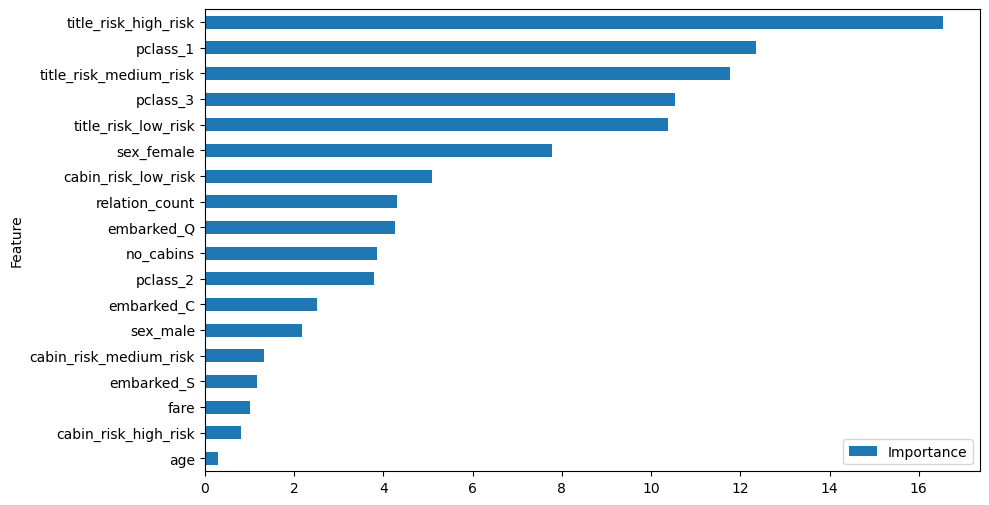

In [72]:
features = logistic_tuned_best.best_estimator_.feature_names_in_
coefficients = logistic_tuned_best.best_estimator_.coef_[0]
total_sum_coeff = np.sum(np.abs(coefficients))
coefficients_ratio = [(coeff*100.00)/total_sum_coeff for coeff in np.abs(coefficients)]
feature_importance = pd.DataFrame({'Feature': features, 'Importance': coefficients_ratio})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [76]:
svc_tuned = svm.SVC()
param_grid = [{
    'kernel':['rbf'],
    'gamma':[0.01,0.1,1,10,50,100],
    'C':[0.01,0.1,1,10,50,100]
    },
    {
    'kernel':['linear'],
    'C':[0.01,0.1,1,10,50,100]
    },
    {
    'kernel':['poly'],
    'degree':[2,3,5,7,9,15],
    'C':[0.01,0.1,1,10,50,100]
    }]

svc_tuned = perform_tuning(modelname="SVC",
                                     model=svc_tuned,param_grid=param_grid,
                                     X=X_model_train,
                                     Y=y_model_train,cv=3)


Fitting 3 folds for each of 78 candidates, totalling 234 fits
For Model:SVC: 
Best Score:  0.8327921840492593
Best Paramter:  {'C': 100, 'kernel': 'linear'}


In [77]:
help(RandomForestClassifier())

Help on RandomForestClassifier in module sklearn.ensemble._forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  For a comparison between tree-based ensemble models see the example
 |  :ref:`s

In [97]:
rf_classifier_tuned = RandomForestClassifier()
param_grid = {
    'n_estimators':[5,10,25,50,100,150,200,300,500,1000],
    'criterion':['gini','entropy'],
    'max_depth':[10,20,50,75,100,150,200],
    'n_jobs':[-1],
    'random_state':[404]
}

rf_classifier_tuned = perform_tuning(modelname="RandomForest",
                                     model=rf_classifier_tuned,param_grid=param_grid,
                                     X=X_model_train,
                                     Y=y_model_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
For Model:RandomForest: 
Best Score:  0.8203125
Best Paramter:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 404}


In [80]:
help(XGBClassifier())

Help on XGBClassifier in module xgboost.sklearn object:

class XGBClassifier(XGBModel, XGBClassifierMixIn, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic', **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : Optional[int]
 |          Number of boosting rounds.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      max_leaves :
 |          Maximum number of leaves; 0 indicates no limit.
 |      max_bin :
 |          If using histogram-based algorithm, maximum number of bins per feature
 |      grow_policy :
 |          Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
 |          depth-wise. 1: favor splitting at 

In [85]:
xgb_classifier_tuned = XGBClassifier()
param_grid = {
    'n_estimators':[5,10,20,50,75,100,150,200,400,600,750],
    'max_depth':[None],
    'booster':['gbtree','gblinear','dart'],
    'n_jobs':[-1],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'learning_rate':[0.1],
    'sampling_method':['uniform']
}

xgb_classifier_tuned = perform_tuning(modelname="XGBoost",
                                     model=xgb_classifier_tuned,param_grid=param_grid,
                                     X=X_model_train,
                                     Y=y_model_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 5/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=5, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=75, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 1/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=100, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=150, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 3/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=150, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=10, n_estimators=10, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 3/5] END booster=gbtree, grow_policy=0, max_depth=10, n_

/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, U

[CV 4/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=5, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 3/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=10, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 4/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=10, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 5/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=10, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=10, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 5/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=20, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 1/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=50, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 2/5

serWarning)
/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.

[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=5, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 3/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=20, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 1/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=75, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 5/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=100, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 5/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=200, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 1/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=200, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 3/5] END booster=gbtree, grow_policy=0, max_depth=10, n_estimators=10, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV

/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhruvdangwal/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sampling_method" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=5, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=20, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 5/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=20, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 1/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=75, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 3/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=100, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 1/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=150, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=150, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 

[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=10, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 4/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=20, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 2/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=50, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.0s
[CV 4/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=50, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 3/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=75, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 5/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=100, n_jobs=-1, sampling_method=gradient_based;, score=nan total time=   0.0s
[CV 3/5] END booster=gbtree, grow_policy=0, max_depth=5, n_estimators=200, n_jobs=-1, sampling_method=uniform;, score=nan total time=   0.

For Model:XGBoost: 
Best Score:  0.84375
Best Paramter:  {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 200, 'n_jobs': -1, 'reg_alpha': 1, 'reg_lambda': 10, 'sampling_method': 'uniform'}


In [91]:
def get_performance_gain(model_name,baseline_model,tuned_model,x,y):
    y_pred_baseline = baseline_model.predict(x)
    y_pred_tuned = tuned_model.predict(x)
    print(f"For {model_name} baseline: ", accuracy_score(y,y_pred_baseline))
    print(f"For {model_name} tuned: ", accuracy_score(y,y_pred_tuned))


In [89]:
### Getting all best tuned models post hyperparameter tuning
logistic_baseline_model = logistic_regression
logistic_best_model = logistic_tuned_best.best_estimator_
svc_baseline_model = svm_reg
svc_best_model = svc_tuned.best_estimator_
rf_classifier_baseline_model = rf_classifier
rf_classifier_best_model = rf_classifier_tuned.best_estimator_
xgb_classifier_baseline_model = xgbst_classifier
xgb_classifier_best_model = xgb_classifier_tuned.best_estimator_


### Ensemble Approach

In [102]:
from sklearn.ensemble import VotingClassifier

In [113]:
vote_classifier_baseline_hard = VotingClassifier(estimators = [('lr',logistic_baseline_model),('rf',rf_classifier_baseline_model),('xgb',xgb_classifier_baseline_model)]
                                           , voting='hard')
vote_classifier_baseline_hard.fit(X_model_train,y_model_train)

vote_classifier_baseline_soft = VotingClassifier(estimators = [('lr',logistic_baseline_model),('rf',rf_classifier_baseline_model),('xgb',xgb_classifier_baseline_model)]
                                           , voting='soft')
vote_classifier_baseline_soft.fit(X_model_train,y_model_train)

vote_classifier_best_soft = VotingClassifier(estimators = [('lr',logistic_best_model),('rf',rf_classifier_baseline_model),('xgb',xgb_classifier_best_model)]
                                           , voting='soft')
vote_classifier_best_soft.fit(X_model_train,y_model_train)

vote_classifier_best_hard = VotingClassifier(estimators = [('lr',logistic_best_model),('svc',svc_best_model),('rf',rf_classifier_baseline_model),('xgb',xgb_classifier_best_model)]
                                           , voting='hard')
vote_classifier_best_hard.fit(X_model_train,y_model_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 solver='liblinear')),
                             ('svc', SVC(C=100, kernel='linear')),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     random_state=234)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rou...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [114]:
#### ON VALIDATION SET
get_performance_gain('Logistic',logistic_baseline_model,logistic_best_model,X_cv,y_cv)
get_performance_gain('SVC',svc_baseline_model,svc_best_model,X_cv,y_cv)
get_performance_gain('Random Forest',rf_classifier_baseline_model,rf_classifier_best_model,X_cv,y_cv)
get_performance_gain('XG-Boost',xgb_classifier_baseline_model,xgb_classifier_best_model,X_cv,y_cv)
get_performance_gain('vote_classifier_baseline_soft_hard',vote_classifier_baseline_hard,vote_classifier_baseline_soft,X_cv,y_cv)
get_performance_gain('vote_classifier_best_soft_hard',vote_classifier_best_hard,vote_classifier_best_soft,X_cv,y_cv)

For Logistic baseline:  0.8333333333333334
For Logistic tuned:  0.8333333333333334
For SVC baseline:  0.6666666666666666
For SVC tuned:  0.8194444444444444
For Random Forest baseline:  0.8472222222222222
For Random Forest tuned:  0.7638888888888888
For XG-Boost baseline:  0.8333333333333334
For XG-Boost tuned:  0.8611111111111112
For vote_classifier_baseline_soft_hard baseline:  0.8472222222222222
For vote_classifier_baseline_soft_hard tuned:  0.8611111111111112
For vote_classifier_baseline_soft_hard baseline:  0.8333333333333334
For vote_classifier_baseline_soft_hard tuned:  0.8611111111111112


In [115]:
#### ON Training Test SET
get_performance_gain('Logistic',logistic_baseline_model,logistic_best_model,X_test,y_test)
get_performance_gain('SVC',svc_baseline_model,svc_best_model,X_test,y_test)
get_performance_gain('Random Forest',rf_classifier_baseline_model,rf_classifier_best_model,X_test,y_test)
get_performance_gain('XG-Boost',xgb_classifier_baseline_model,xgb_classifier_best_model,X_test,y_test)
get_performance_gain('vote_classifier_baseline_soft_hard',vote_classifier_baseline_hard,vote_classifier_baseline_soft,X_test,y_test)
get_performance_gain('vote_classifier_best_soft_hard',vote_classifier_best_hard,vote_classifier_best_soft,X_test,y_test)

For Logistic baseline:  0.7821229050279329
For Logistic tuned:  0.7821229050279329
For SVC baseline:  0.7541899441340782
For SVC tuned:  0.770949720670391
For Random Forest baseline:  0.7877094972067039
For Random Forest tuned:  0.7597765363128491
For XG-Boost baseline:  0.7821229050279329
For XG-Boost tuned:  0.8100558659217877
For vote_classifier_baseline_soft_hard baseline:  0.7821229050279329
For vote_classifier_baseline_soft_hard tuned:  0.776536312849162
For vote_classifier_best_soft_hard baseline:  0.7877094972067039
For vote_classifier_best_soft_hard tuned:  0.8156424581005587


In [116]:
##### produce results
produce_results("tuned_logistic",logistic_best_model,X_final_test,X_final_passengerid)
produce_results("tuned_svc",svc_best_model,X_final_test,X_final_passengerid)
produce_results("tuned_random_forest",rf_classifier_best_model,X_final_test,X_final_passengerid)
produce_results("tuned_xgboost",xgb_classifier_best_model,X_final_test,X_final_passengerid)
produce_results("vote_ensemble_soft",vote_classifier_best_soft,X_final_test,X_final_passengerid)


